<a href="https://colab.research.google.com/github/Hydroenvironment/homogeneity/blob/main/homogeneity_notebook_V1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRUEDAS DE HOMOGENEIDAD EN SERIES DE TIEMPO**

In [1]:
################################################################################
# HOMOGENEITY ASSESSMENT AND CHANGE-POINT DETECTION                          #
# IN HYDROMETEOROLOGICAL TIME SERIES                                         #
################################################################################

#Author: Julio Montenegro-Gambini, M.Sc.
#PhD Researcher - Technische Universiteit Delft (TU Delft), Netherlands.

#Current version: 1.0

# © Copyright 2025 Julio Montenegro-Gambini.
# This script is strictly under license GPLv3
# License details: https://www.gnu.org/licenses/gpl-3.0.en.html

# 🛡️ Licence: GNU General Public License v3.0 (GPL-3.0) (Python cells, Bash, executable scripts)
# 🛡️ Licence: Creative Commons CC‑BY‑SA‑4.0 (GPL-3.0) (text, examples, explanatory comments)

## ✅ Permissions:
##- Use, copying and modification are permitted.
##- It may be used for educational, professional and commercial purposes.
## ❌ Restrictions:
##- **The original authorship must be retained.**
##- **Comments, credits, or author mentions may not be removed, modified, or hidden.**
##- **Any redistribution must include these same licenses (GPL-3.0)(CC‑BY‑SA‑4.0).**
##- **Removing or modifying the author's credits in the code or documentation.
## ℹ️ More information: See license files in the github repositoryu#

##📝
##If you use, adapt or reproduce any part of this notebook in a publication, thesis, report, presentation or derivative notebook, please **cite it as follows** (**APA 7th Edition**):
##"Montenegro, J. (2025). *"Multi‑Scale Homogeneity assessment and change-point detection in hydrometeorological time series"*
##GitHub. https://github.com/Hydroenvironment/homogeneity


In [ ]:
# --- Install Required Libraries ---
!pip install --quiet numpy pandas matplotlib seaborn xarray openpyxl
!pip install --quiet scipy

In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# --- Setup ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

In [ ]:
# --- Complete Critical Values Tables (95% and 99%) for all supported tests ---

critical_values = {
    "pettitt": {
        10: {0.95: 30, 0.99: 40},
        20: {0.95: 57, 0.99: 71},
        30: {0.95: 107, 0.99: 133},
        40: {0.95: 167, 0.99: 208},
        50: {0.95: 235, 0.99: 293},
        70: {0.95: 393, 0.99: 488},
        100: {0.95: 677, 0.99: 841}
    },
    "snht": {
        10: {0.95: 6.0, 0.99: 7.9},
        20: {0.95: 6.95, 0.99: 9.56},
        30: {0.95: 7.65, 0.99: 10.45},
        40: {0.95: 8.10, 0.99: 11.01},
        50: {0.95: 8.45, 0.99: 11.38},
        70: {0.95: 8.80, 0.99: 11.89},
        100: {0.95: 9.15, 0.99: 12.32}
    },
    "cumulative_dev_qsqrt": {
        10: {0.95: 1.14, 0.99: 1.29},
        20: {0.95: 1.22, 0.99: 1.42},
        30: {0.95: 1.24, 0.99: 1.46},
        40: {0.95: 1.26, 0.99: 1.50},
        50: {0.95: 1.27, 0.99: 1.52},
        100: {0.95: 1.29, 0.99: 1.55}
    },
    "buishand_rsqrt": {
        10: {0.95: 1.28, 0.99: 1.38},
        20: {0.95: 1.43, 0.99: 1.60},
        30: {0.95: 1.50, 0.99: 1.70},
        40: {0.95: 1.53, 0.99: 1.74},
        50: {0.95: 1.55, 0.99: 1.78},
        100: {0.95: 1.62, 0.99: 1.86}
    },
    "buishand_U": {
        10: {0.95: 0.395, 0.99: 0.514},
        20: {0.95: 0.447, 0.99: 0.662},
        30: {0.95: 0.444, 0.99: 0.691},
        40: {0.95: 0.448, 0.99: 0.693},
        50: {0.95: 0.452, 0.99: 0.718},
        100: {0.95: 0.457, 0.99: 0.712}
    },
    "von_neumann": {
        10: {0.95: 1.1, 0.99: 0.9},
        20: {0.95: 1.30, 0.99: 1.04},
        30: {0.95: 1.42, 0.99: 1.20},
        40: {0.95: 1.49, 0.99: 1.29},
        50: {0.95: 1.54, 0.99: 1.36},
        70: {0.95: 1.61, 0.99: 1.45},
        100: {0.95: 1.67, 0.99: 1.54}
    },
    "bayesian_a": {
        10: {0.95: 2.31, 0.99: 3.14},
        20: {0.95: 2.44, 0.99: 3.50},
        30: {0.95: 2.42, 0.99: 3.70},
        40: {0.95: 2.44, 0.99: 3.66},
        50: {0.95: 2.48, 0.99: 3.78},
        100: {0.95: 2.48, 0.99: 3.82}
    },
    "worsley_w": {
        15: {0.95: 3.36, 0.99: 4.32},
        20: {0.95: 3.28, 0.99: 4.13},
        25: {0.95: 3.23, 0.99: 3.94},
        30: {0.95: 3.19, 0.99: 3.86},
        40: {0.95: 3.17, 0.99: 3.84},
        45: {0.95: 3.16, 0.99: 3.79},
        50: {0.95: 3.16, 0.99: 3.79}
    }
}

def get_nearest_n(n, test_name):
    """Return the closest available sample size for a given test."""
    available_n = list(critical_values.get(test_name, {}).keys())
    return min(available_n, key=lambda x: abs(x - n)) if available_n else None

def get_critical_value(test_name, n, alpha=0.95):
    """Lookup critical value for a specific test, sample size, and confidence level."""
    rounded_n = get_nearest_n(n, test_name)
    if rounded_n is None:
        return None
    return critical_values[test_name].get(rounded_n, {}).get(alpha, None)

In [ ]:
get_critical_value("worsley_w",50000000000, alpha=0.95)

3.16

In [ ]:
# --- Load Dataset ---
# 👉 Replace 'your_file.xlsx' and 'Sheet1' with your own file and sheet name
file_path = 'synthetic_rainfall_1961_2009.xlsx'  # upload your Excel file in the left panel
sheet_name = 'MonthlyRainfall'  # your sheet name

df = pd.read_excel(file_path, sheet_name='MonthlyRainfall')
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,Barkhan,Dalbandin,Jiwani,Kalat,Khuzdar,Zhob
Unnamed: 0,,,,,,
1961-01-01,24.967142,28.303358,3.070432,17.539375,26.835693,29.965705
1961-02-01,43.617357,36.439162,44.016604,36.567534,31.340443,40.335046
1961-03-01,69.778156,64.016933,53.415359,85.010697,75.420710,69.706068
1961-04-01,85.230299,65.223426,58.964107,68.241142,72.612505,68.094969
1961-05-01,60.959736,68.091068,65.100212,64.533318,59.608499,66.541840


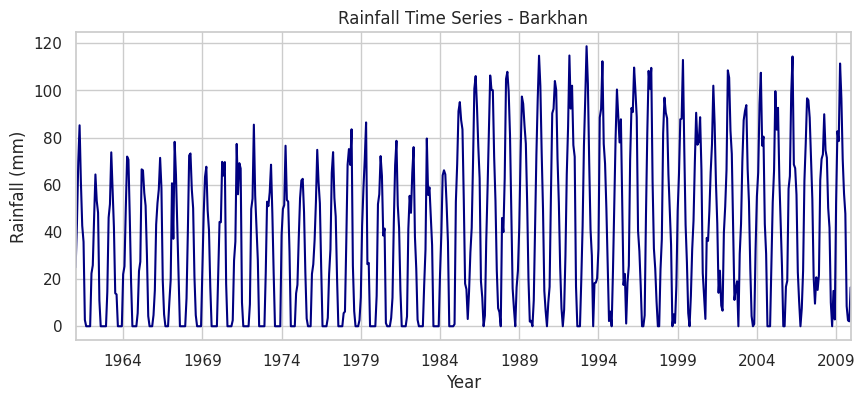

In [ ]:
# --- Helper: Plot Monthly Series ---
def plot_station(station):
    df[station].plot(title=f"Rainfall Time Series - {station}", color='navy')
    plt.ylabel("Rainfall (mm)")
    plt.xlabel("Year")
    plt.show()
plot_station("Barkhan")

In [ ]:
# --- Homogeneity Tests ---

# 1. Pettitt's Test
def pettitt_test(x):
    n = len(x)
    K = np.zeros(n)
    for t in range(n):
        r1 = x[:t+1]
        r2 = x[t+1:]
        if len(r1) == 0 or len(r2) == 0:
            K[t] = 0
        else:
            u_stat = stats.mannwhitneyu(r1, r2, alternative='two-sided')[0]
            K[t] = u_stat
    K = np.abs(K)
    Kt = np.argmax(K)
    p_value = 2 * np.exp((-6 * K[Kt]**2) / (n**3 + n**2))
    return Kt, p_value

In [ ]:
# 2. SNHT (Standard Normal Homogeneity Test)
def snht_test(x):
    x = np.array(x)
    n = len(x)
    xbar = np.mean(x)
    s = np.std(x)
    T = np.array([((np.mean(x[:i+1]) - xbar)**2 + (np.mean(x[i+1:]) - xbar)**2) * (i+1)*(n-i-1)/n/s**2 for i in range(1, n-1)])
    return np.max(T), np.argmax(T)+1

In [ ]:
# 3. Cumulative Deviation Test
def cumulative_dev_test(x):
    xbar = np.mean(x)
    s = np.std(x)
    Sk = np.cumsum(x - xbar) / s
    Q = np.max(np.abs(Sk))
    return Q

In [ ]:
def buishand_range_test(x):
    """
    Buishand Range Test (Q): Cumulative deviation test from mean.
    Critical value at 95% for n=49 is ~1.27 (already included in the paper).
    """
    n = len(x)
    xbar = np.mean(x)
    Sk = np.cumsum(x - xbar)
    R = np.max(Sk) - np.min(Sk)
    s = np.std(x, ddof=1)
    Q = R / s
    return Q

In [ ]:
def buishand_u_test(x):
    """
    Buishand U Test (Standardized range of cumulative deviations)
    U = (1/n) * sum(Sk^2) / s^2
    """
    n = len(x)
    xbar = np.mean(x)
    Sk = np.cumsum(x - xbar)
    s2 = np.var(x, ddof=1)
    U = (1 / n) * np.sum(Sk**2) / s2
    return U

In [ ]:
# 4. Von Neumann Test
def von_neumann_test(x):
    x = np.array(x)
    diff = np.diff(x)
    num = np.sum(diff**2)
    denom = np.sum((x - np.mean(x))**2)
    N = num / denom
    return N

In [ ]:
# 5. Bayesian Test (simplified as rescaled deviation)
def bayesian_test(x):
    xbar = np.mean(x)
    s = np.std(x)
    Sk = np.cumsum(x - xbar) / s
    A = np.max(np.abs(Sk))
    return A

In [ ]:
# 6. Worsley's Likelihood Ratio (simplified proxy)
def worsley_test(x):
    x = np.array(x)
    n = len(x)
    S = np.cumsum(x - np.mean(x))
    V = np.max(np.abs(S))
    W = (n * V**2) / (np.var(x) * n**2)
    return W

In [ ]:
# 7. Student's t-Test (2 segments)
def student_t_test(x):
    mid = len(x) // 2
    t_stat, p = stats.ttest_ind(x[:mid], x[mid:], equal_var=False)
    return t_stat, p

In [ ]:
# --- Apply All Tests to a Series ---
def apply_all_tests_verbose(series):
    results = {}
    x = series.dropna().values
    if len(x) < 20:
        return {"error": "Too few data points"}
    results['pettitt'] = {'break_at_index': pettitt_test(x)[0], 'p_value': pettitt_test(x)[1]}
    results['snht'] = {'max_T': snht_test(x)[0], 'break_at_index': snht_test(x)[1]}
    results['cumulative_dev'] = {'Q_statistic': cumulative_dev_test(x)}
    results['buishand_range'] = {'Q_statistic': buishand_range_test(x)}
    results['buishand_U'] = {'U_statistic': buishand_u_test(x)}
    results['von_neumann'] = {'N_ratio': von_neumann_test(x)}
    results['bayesian'] = {'A_statistic': bayesian_test(x)}
    results['worsley'] = {'W_statistic': worsley_test(x)}
    student_t_stat, student_p = student_t_test(x)
    results['student_t'] = {'t_statistic': student_t_stat, 'p_value': student_p}
    return results

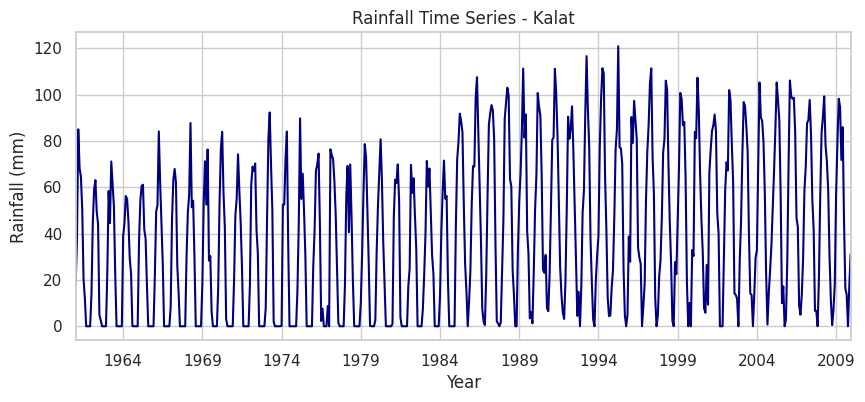

\nPETTITT:
  break_at_index: 366
  p_value: 2.2129765501013686e-10
\nSNHT:
  max_T: 33.764774272939604
  break_at_index: 287
\nCUMULATIVE_DEV:
  Q_statistic: 99.5920586916893
\nBUISHAND_RANGE:
  Q_statistic: 102.9575948937751
\nBUISHAND_U:
  U_statistic: 3199.7149118659268
\nVON_NEUMANN:
  N_ratio: 0.369602135291304
\nBAYESIAN:
  A_statistic: 99.5920586916893
\nWORSLEY:
  W_statistic: 16.86833019464096
\nSTUDENT_T:
  t_statistic: -8.07768381625113
  p_value: 4.026520578878224e-15


In [ ]:
# --- Example Usage ---
station = 'Kalat'  # Choose a station like 'Barkhan', 'Zhob', etc.
plot_station(station)
results = apply_all_tests_verbose(df[station])
for test, metrics in results.items():
    print(f"\\n{test.upper()}:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")

In [ ]:
# --- Generate Tabular Results for All Stations ---
summary = []

for station in df.columns:
    x = df[station].dropna()
    if len(x) < 20:
        continue
    result = apply_all_tests_verbose(x)
    row = {
        'Station': station,
        'Pettitt_Break_Index': result['pettitt']['break_at_index'],
        'Pettitt_p': result['pettitt']['p_value'],
        'SNHT_T': result['snht']['max_T'],
        'SNHT_Break_Index': result['snht']['break_at_index'],
        'Cumulative_Q': result['cumulative_dev']['Q_statistic'],
        'Buishand_R': result['buishand_range']['Q_statistic'],
        'Buishand_U': result['buishand_U']['U_statistic'],
        'Von_Neumann_Ratio': result['von_neumann']['N_ratio'],
        'Bayesian_A': result['bayesian']['A_statistic'],
        'Worsley_W': result['worsley']['W_statistic'],
        't_stat': result['student_t']['t_statistic'],
        't_p_value': result['student_t']['p_value']
    }
    summary.append(row)

summary_df = pd.DataFrame(summary)
summary_df.set_index('Station', inplace=True)
display(summary_df)

,Pettitt_Break_Index,Pettitt_p,SNHT_T,SNHT_Break_Index,Cumulative_Q,Buishand_R,Buishand_U,Von_Neumann_Ratio,Bayesian_A,Worsley_W,t_stat,t_p_value
Station,,,,,,,,,,,,
Barkhan,342,2.172677e-11,33.590705,287,99.335010,103.012524,3012.184995,0.355483,99.335010,16.781368,-7.987835,7.997150e-15
Dalbandin,306,7.273885e-25,4.986405,582,6.308493,12.023392,6.333090,0.422260,6.308493,0.067682,0.102794,9.181616e-01
Jiwani,294,3.858530e-25,4.436248,582,6.559053,11.279124,5.587663,0.429864,6.559053,0.073165,0.223277,8.233975e-01
Kalat,366,2.212977e-10,33.764774,287,99.592059,102.957595,3199.714912,0.369602,99.592059,16.868330,-8.077684,4.026521e-15
Khuzdar,282,3.492221e-25,4.449097,5,7.710362,13.345532,7.629515,0.430421,7.710362,0.101105,0.125065,9.005152e-01
Zhob,305,1.020042e-24,4.865821,4,7.947501,12.654160,8.388491,0.449921,7.947501,0.107420,0.100487,9.199925e-01


In [ ]:
# --- Classification Logic Based on Homogeneity Paper ---
def classify_homogeneity(row, n, alpha):
    rejections = 0
    sqrt_n = np.sqrt(n)

    # Correctly handle Pettitt's test p-value
    if row['Pettitt_p'] < (1 - alpha):
        rejections += 1

    # Handle other tests, checking for None from get_critical_value
    snht_crit = get_critical_value('snht', n, alpha)
    if snht_crit is not None and row['SNHT_T'] > snht_crit:
        rejections += 1

    cum_dev_crit = get_critical_value('cumulative_dev_qsqrt', n, alpha)
    if cum_dev_crit is not None and row['Cumulative_Q'] / sqrt_n > cum_dev_crit:
        rejections += 1

    buishand_r_crit = get_critical_value('buishand_rsqrt', n, alpha)
    if buishand_r_crit is not None and row['Buishand_R'] / sqrt_n > buishand_r_crit:
        rejections += 1

    buishand_u_crit = get_critical_value('buishand_U', n, alpha)
    if buishand_u_crit is not None and row['Buishand_U'] > buishand_u_crit:
        rejections += 1

    von_neumann_crit = get_critical_value('von_neumann', n, alpha)
    if von_neumann_crit is not None and row['Von_Neumann_Ratio'] < von_neumann_crit:
        rejections += 1

    bayesian_crit = get_critical_value('bayesian_a', n, alpha)
    if bayesian_crit is not None and row['Bayesian_A'] > bayesian_crit:
        rejections += 1

    worsley_crit = get_critical_value('worsley_w', n, alpha)
    if worsley_crit is not None and row['Worsley_W'] > worsley_crit:
        rejections += 1

    if row['t_p_value'] < 1 - alpha:
        rejections += 1

    if rejections <= 3:
        return 'A (Useful)'
    elif rejections == 4:
        return 'B (Doubtful)'
    else:
        return 'C (Suspect)'

In [ ]:
# Apply classification
summary_df['n_points'] = df.apply(lambda col: col.dropna().shape[0])
summary_df['Homogeneity_Class'] = summary_df.apply(
    lambda row: classify_homogeneity(row, int(row['n_points']), alpha=0.95), axis=1)
display(summary_df)

,Pettitt_Break_Index,Pettitt_p,SNHT_T,SNHT_Break_Index,Cumulative_Q,Buishand_R,Buishand_U,Von_Neumann_Ratio,Bayesian_A,Worsley_W,t_stat,t_p_value,n_points,Homogeneity_Class
Station,,,,,,,,,,,,,,
Barkhan,342,2.172677e-11,33.590705,287,99.335010,103.012524,3012.184995,0.355483,99.335010,16.781368,-7.987835,7.997150e-15,588,C (Suspect)
Dalbandin,306,7.273885e-25,4.986405,582,6.308493,12.023392,6.333090,0.422260,6.308493,0.067682,0.102794,9.181616e-01,588,B (Doubtful)
Jiwani,294,3.858530e-25,4.436248,582,6.559053,11.279124,5.587663,0.429864,6.559053,0.073165,0.223277,8.233975e-01,588,B (Doubtful)
Kalat,366,2.212977e-10,33.764774,287,99.592059,102.957595,3199.714912,0.369602,99.592059,16.868330,-8.077684,4.026521e-15,588,C (Suspect)
Khuzdar,282,3.492221e-25,4.449097,5,7.710362,13.345532,7.629515,0.430421,7.710362,0.101105,0.125065,9.005152e-01,588,B (Doubtful)
Zhob,305,1.020042e-24,4.865821,4,7.947501,12.654160,8.388491,0.449921,7.947501,0.107420,0.100487,9.199925e-01,588,B (Doubtful)


In [ ]:
# --- Enhanced Visualize Breakpoint Detection with Annotations ---
def plot_breakpoints(station):
    series = df[station].dropna()
    x = series.values
    index = series.index

    # Pettitt's break
    p_break_idx = int(pettitt_test(x)[0])
    p_break_date = index[p_break_idx]
    p_break_val = x[p_break_idx]

    # SNHT break
    snht_break_idx = int(snht_test(x)[1])
    snht_break_date = index[snht_break_idx]
    snht_break_val = x[snht_break_idx]

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(index, x, label='Rainfall', color='black')

    plt.axvline(p_break_date, color='red', linestyle='--', label=f'Pettitt Break: {p_break_date.date()}')
    plt.axvline(snht_break_date, color='blue', linestyle='--', label=f'SNHT Break: {snht_break_date.date()}')

    # Annotate values
    plt.text(p_break_date, p_break_val + 5, f'{p_break_val:.1f} mm', color='red')
    plt.text(snht_break_date, snht_break_val + 5, f'{snht_break_val:.1f} mm', color='blue')

    plt.title(f'Breakpoint Detection - {station}')
    plt.xlabel('Year')
    plt.ylabel('Rainfall (mm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

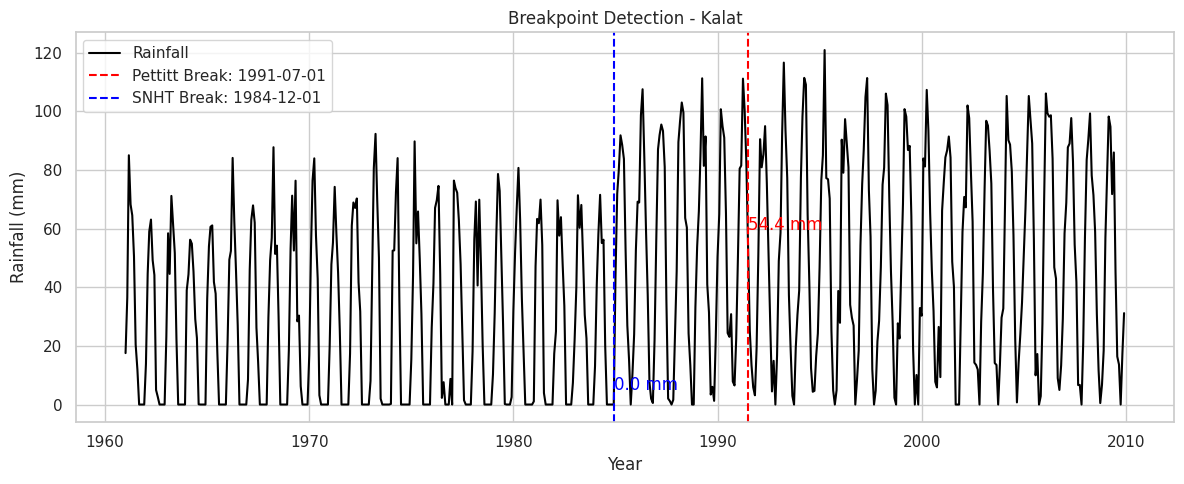

In [ ]:
# Example
plot_breakpoints('Kalat')  # Replace with any station name

In [ ]:
# --- USER SELECTION ---
aggregation_mode = 'sum'  # 'sum' or 'mean'
aggregation_type = 'seasonal'  # 'monthly', 'seasonal', or 'annual'
alpha = 0.95  # Significance level

In [ ]:
def aggregate_series(df, agg_type, agg_mode):
    assert agg_type in ['monthly', 'seasonal', 'annual']
    assert agg_mode in ['mean', 'sum']

    df_copy = df.copy()
    method = getattr(df_copy.resample('M'), agg_mode)
    df_monthly = method()

    if agg_type == 'monthly':
        month_names = {
            1: 'January', 2: 'February', 3: 'March', 4: 'April',
            5: 'May', 6: 'June', 7: 'July', 8: 'August',
            9: 'September', 10: 'October', 11: 'November', 12: 'December'
        }
        return {
            month_names[m]: df_monthly[df_monthly.index.month == m]
            for m in range(1, 13)
        }

    elif agg_type == 'seasonal':
        # Meteorological season names
        season_mapping = {
            'DJF': 'DJF - Summer',
            'MAM': 'MAM - Autumn',
            'JJA': 'JJA - Winter',
            'SON': 'SON - Spring'
        }
        seasons = {
            'DJF': [12, 1, 2],
            'MAM': [3, 4, 5],
            'JJA': [6, 7, 8],
            'SON': [9, 10, 11]
        }
        seasonal_data = {}
        for code, months in seasons.items():
            name = season_mapping[code]
            seasonal_data[name] = df_monthly[df_monthly.index.month.isin(months)]
        return seasonal_data

    elif agg_type == 'annual':
        df_annual = getattr(df_copy.resample('Y'), agg_mode)()
        return {'Annual': df_annual}

In [ ]:
def run_aggregated_homogeneity(df, agg_type, agg_mode):
    subsets = aggregate_series(df, agg_type, agg_mode)
    results = []

    for label, subset_df in subsets.items():
        for station in subset_df.columns:
            series = subset_df[station].dropna()
            if len(series) < 20:
                continue
            result = apply_all_tests_verbose(series)
            n = len(series)
            row = {
                'Period': label,  # Now contains month or season name
                'Station': station,
                'n_points': n,
                'Pettitt_p': result['pettitt']['p_value'],
                'SNHT_T': result['snht']['max_T'],
                'Cumulative_Q': result['cumulative_dev']['Q_statistic'],
                'Buishand_R': result['buishand_range']['Q_statistic'],
                'Buishand_U': result['buishand_U']['U_statistic'],
                'Von_Neumann_Ratio': result['von_neumann']['N_ratio'],
                'Bayesian_A': result['bayesian']['A_statistic'],
                'Worsley_W': result['worsley']['W_statistic'],
                't_stat': result['student_t']['t_statistic'],
                't_p_value': result['student_t']['p_value']
            }
            results.append(row)
    return pd.DataFrame(results)

In [ ]:
results_df = run_aggregated_homogeneity(df, agg_type=aggregation_type, agg_mode=aggregation_mode)

results_df['Homogeneity_Class'] = results_df.apply(
    lambda row: classify_homogeneity(row, row['n_points'], alpha=alpha), axis=1)

results_df.reset_index(drop=True, inplace=True)
display(results_df)

/tmp/ipython-input-287022195.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  method = getattr(df_copy.resample('M'), agg_mode)
/tmp/ipython-input-2003055668.py:7: RuntimeWarning: invalid value encountered in scalar divide
  T = np.array([((np.mean(x[:i+1]) - xbar)**2 + (np.mean(x[i+1:]) - xbar)**2) * (i+1)*(n-i-1)/n/s**2 for i in range(1, n-1)])
/tmp/ipython-input-2197076120.py:5: RuntimeWarning: invalid value encountered in divide
  Sk = np.cumsum(x - xbar) / s
/tmp/ipython-input-2413721777.py:11: RuntimeWarning: invalid value encountered in scalar divide
  Q = R / s
/tmp/ipython-input-1903881038.py:10: RuntimeWarning: invalid value encountered in scalar divide
  U = (1 / n) * np.sum(Sk**2) / s2


,Period,Station,n_points,Pettitt_p,SNHT_T,Cumulative_Q,Buishand_R,Buishand_U,Von_Neumann_Ratio,Bayesian_A,Worsley_W,t_stat,t_p_value,Homogeneity_Class
0,DJF - Summer,Barkhan,147,7.026457e-02,23.872435,41.870789,42.521208,564.885600,1.916317,41.870789,11.926279,-8.161692,1.860935e-13,C (Suspect)
1,DJF - Summer,Dalbandin,147,4.813084e-06,1.408764,4.572687,5.743993,5.153475,2.876777,4.572687,0.142241,-0.623789,5.337609e-01,A (Useful)
2,DJF - Summer,Jiwani,147,6.631186e-07,1.657619,3.673649,6.261956,2.131883,2.820558,3.673649,0.091807,0.056666,9.548892e-01,A (Useful)
3,DJF - Summer,Kalat,147,5.988937e-02,21.648152,39.872476,39.946012,508.838036,2.052826,39.872476,10.815064,-7.709578,1.871981e-12,C (Suspect)
4,DJF - Summer,Khuzdar,147,8.998518e-07,1.379853,3.460909,6.331070,1.632726,2.752502,3.460909,0.081482,-0.114077,9.093355e-01,A (Useful)
5,DJF - Summer,Zhob,147,2.107865e-06,1.023699,4.255532,7.394118,3.380281,2.769201,4.255532,0.123194,-0.451846,6.520556e-01,A (Useful)
6,MAM - Autumn,Barkhan,147,2.117750e-01,50.370919,60.820884,60.613657,1167.030451,0.655139,60.820884,25.164489,-17.223581,7.093564e-37,C (Suspect)
7,MAM - Autumn,Dalbandin,147,6.732649e-05,3.949414,15.693040,19.795077,75.072057,1.855607,15.693040,1.675316,-2.561664,1.144523e-02,C (Suspect)
8,MAM - Autumn,Jiwani,147,3.528820e-07,2.026481,6.106409,10.940239,6.271837,2.285156,6.106409,0.253661,0.218842,8.270811e-01,A (Useful)
9,MAM - Autumn,Kalat,147,4.375825e-01,45.928875,58.094722,58.366659,1155.302866,0.762944,58.094722,22.959162,-15.533325,1.276930e-32,C (Suspect)


In [ ]:
def plot_aggregated_breakpoints(station, agg_type, agg_mode):
    """
    Plot rainfall series by station and aggregation type (monthly/seasonal/annual),
    and mark Pettitt and SNHT breakpoints with value and date.
    """
    import matplotlib.dates as mdates

    subsets = aggregate_series(df, agg_type=agg_type, agg_mode=agg_mode)

    for label, subset_df in subsets.items():
        if station not in subset_df.columns:
            continue

        series = subset_df[station].dropna()
        if len(series) < 20:
            print(f"Skipping {label} — not enough data.")
            continue

        x = series.values
        dates = series.index

        # Pettitt breakpoint
        p_idx = pettitt_test(x)[0]
        p_val = x[p_idx]
        p_date = dates[p_idx]

        # SNHT breakpoint
        snht_stat, snht_idx = snht_test(x)
        s_val = x[snht_idx]
        s_date = dates[snht_idx]

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(dates, x, label=f'{agg_type.title()} Rainfall', color='black')

        # Mark Pettitt
        plt.axvline(p_date, color='red', linestyle='--', label=f'Pettitt: {p_date.date()}')
        plt.text(p_date, p_val + 3, f'{p_val:.1f} mm', color='red')

        # Mark SNHT
        plt.axvline(s_date, color='blue', linestyle='--', label=f'SNHT: {s_date.date()}')
        plt.text(s_date, s_val + 3, f'{s_val:.1f} mm', color='blue')

        # Format
        plt.title(f'{agg_type.title()} Breakpoints - {station} - {label}')
        plt.ylabel('Rainfall (mm)')
        plt.xlabel('Date')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

/tmp/ipython-input-287022195.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  method = getattr(df_copy.resample('M'), agg_mode)


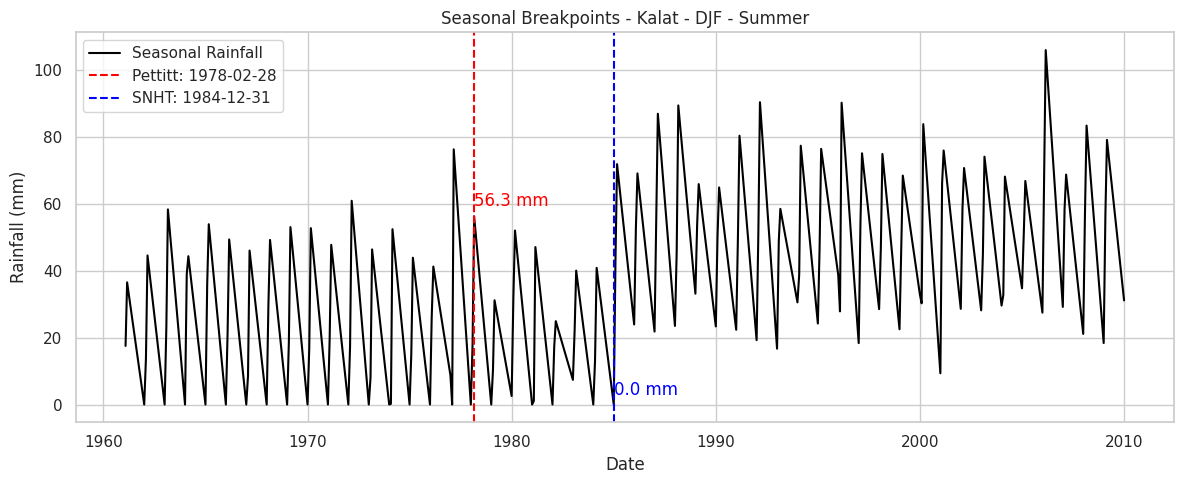

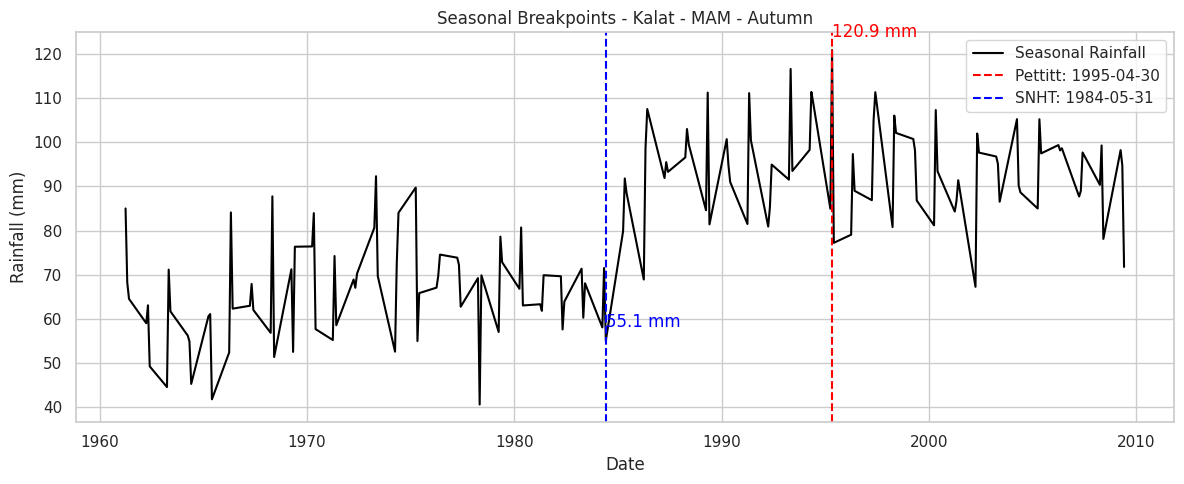

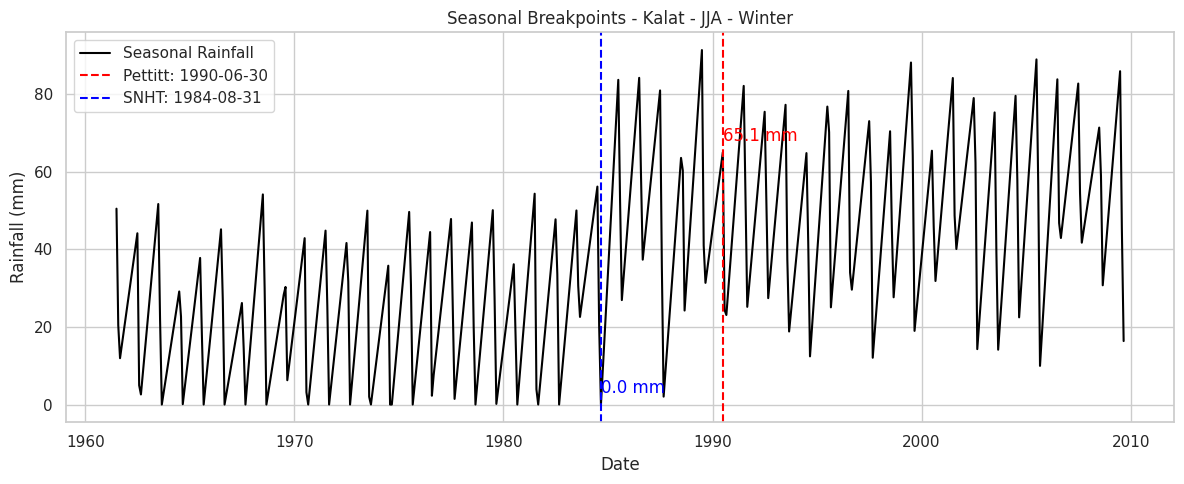

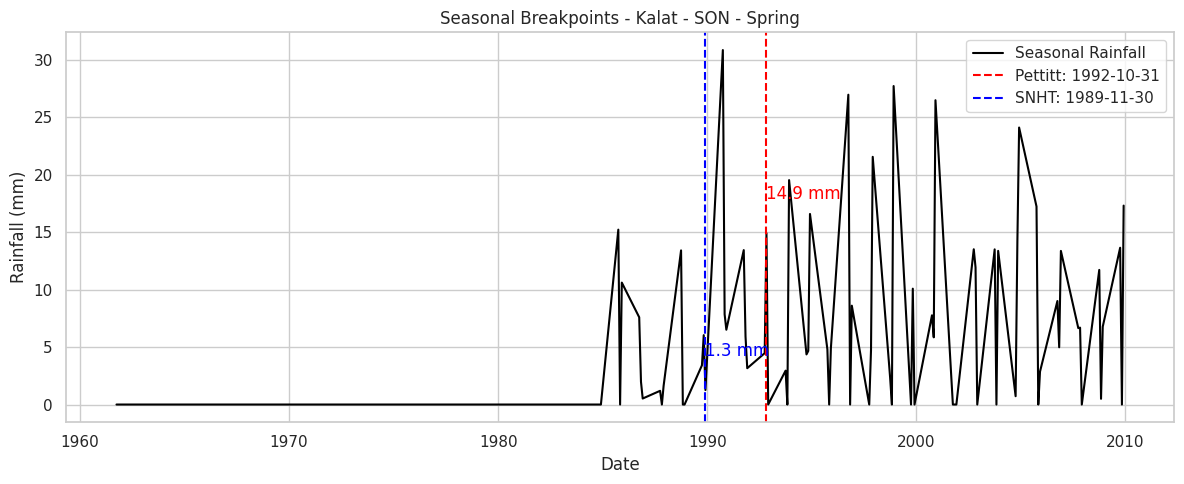

In [ ]:
plot_aggregated_breakpoints("Kalat", agg_type="monthly", agg_mode="sum")

/tmp/ipython-input-341533597.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  method = getattr(df_copy.resample('M'), agg_mode)


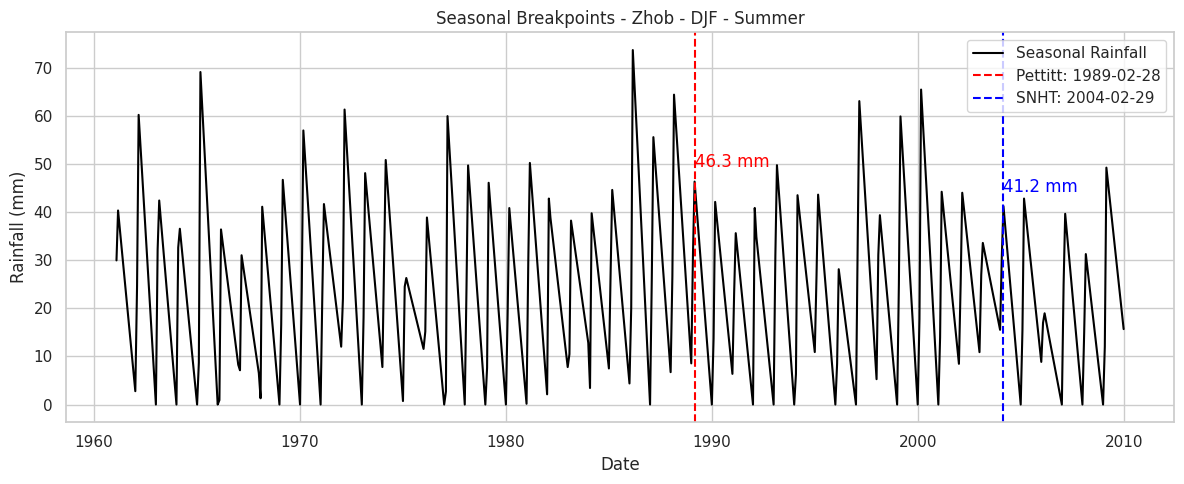

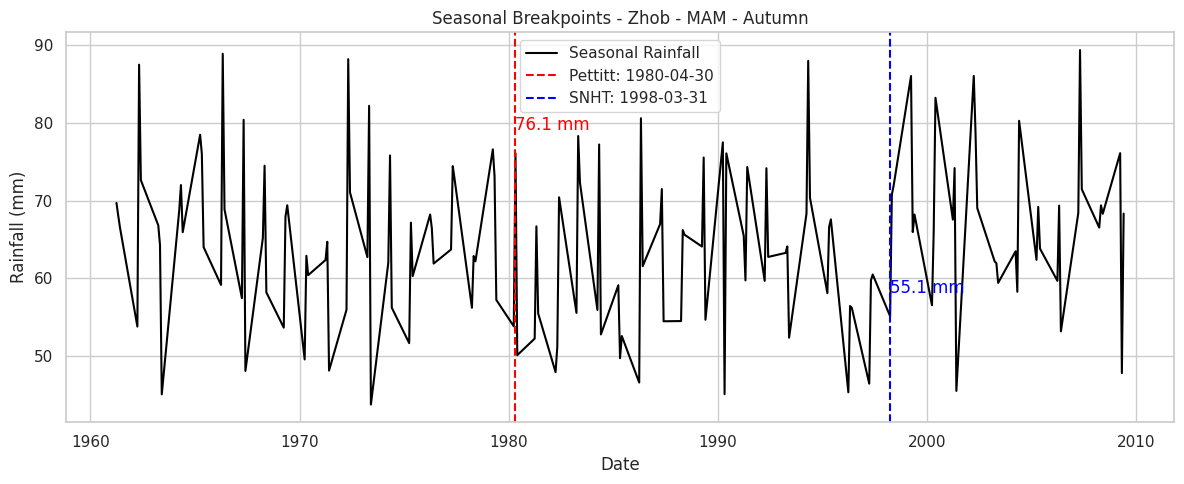

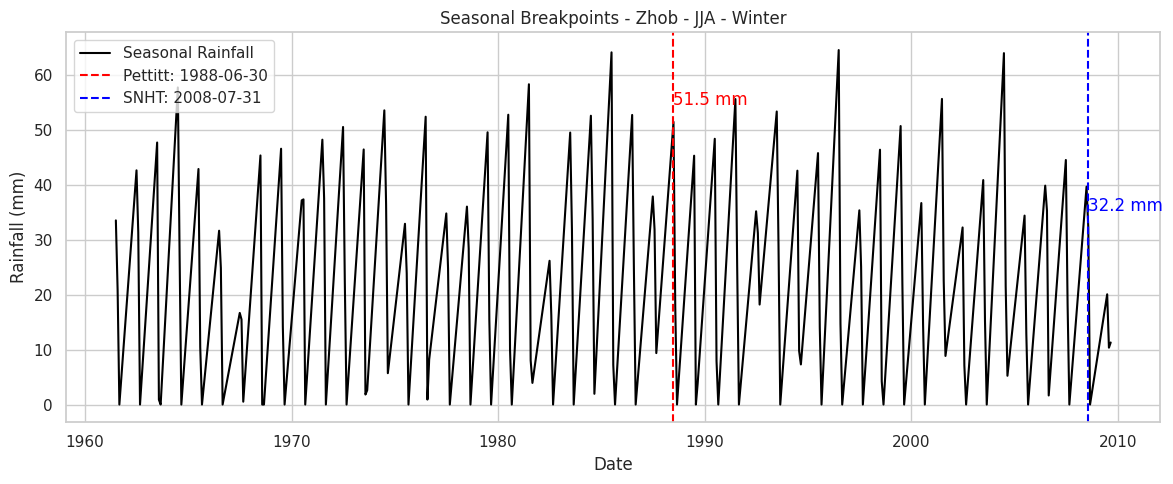

/tmp/ipython-input-2003055668.py:7: RuntimeWarning: invalid value encountered in scalar divide
  T = np.array([((np.mean(x[:i+1]) - xbar)**2 + (np.mean(x[i+1:]) - xbar)**2) * (i+1)*(n-i-1)/n/s**2 for i in range(1, n-1)])
/tmp/ipython-input-120739942.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


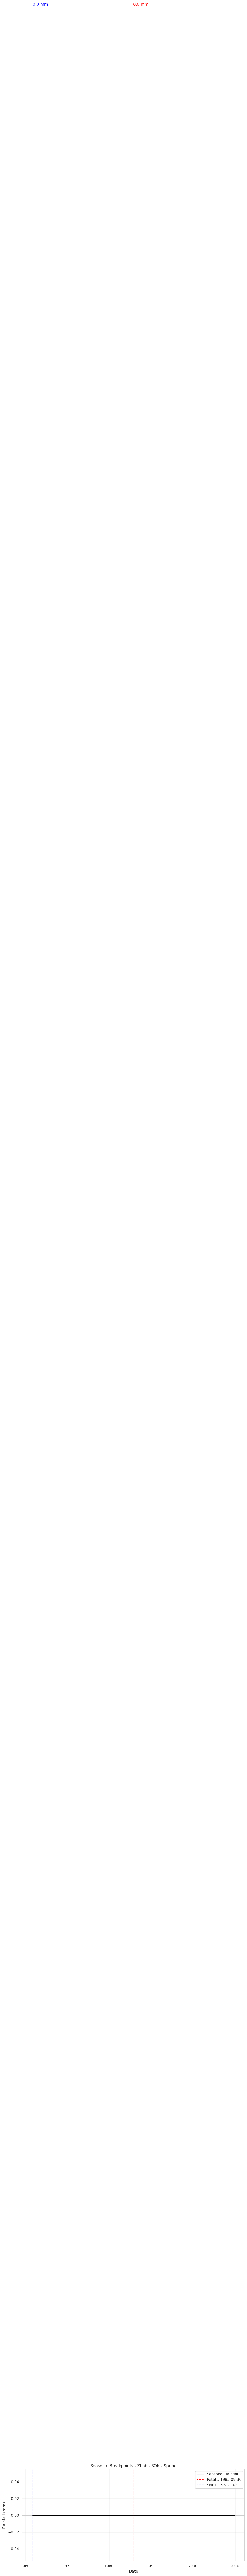

In [ ]:
plot_aggregated_breakpoints("Zhob", agg_type="seasonal", agg_mode="sum")

/tmp/ipython-input-287022195.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  method = getattr(df_copy.resample('M'), agg_mode)
/tmp/ipython-input-287022195.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = getattr(df_copy.resample('Y'), agg_mode)()


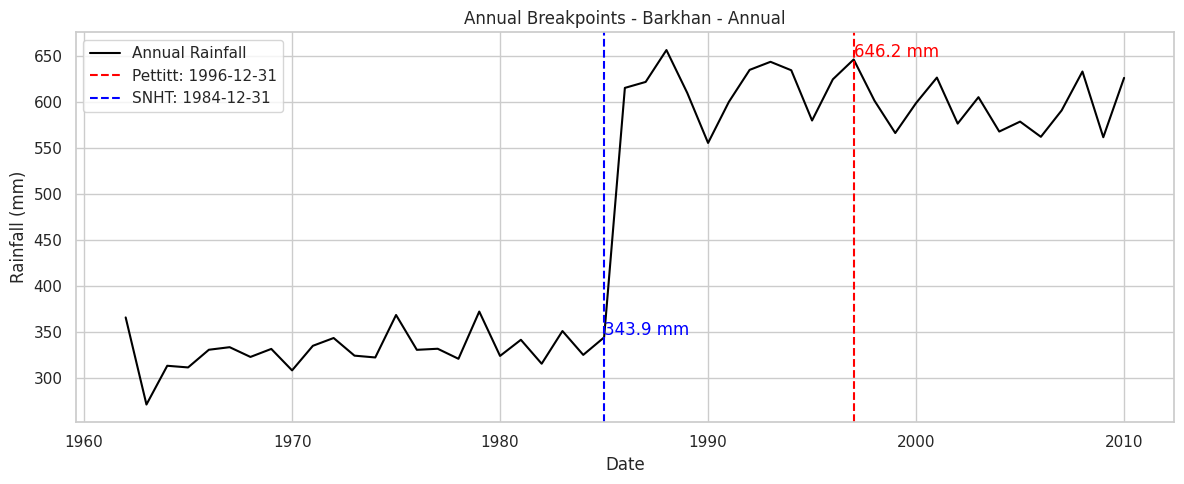

In [ ]:
plot_aggregated_breakpoints("Barkhan", agg_type="annual", agg_mode="sum")